In [60]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold,StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.pyplot import figure
import seaborn as sn

In [61]:
DATA_PATH="/Users/zubrikhina/Documents/datasets/EEG_baseline_with_markers/all_data_features"

## Extract important features from the best model and build correlation matrix on it

In [62]:
excluded_feature_methods = [
     'asMap.csv',
    'fr_assym.csv',
    
]

In [63]:
all_datas =[]
for path in Path(DATA_PATH).iterdir():
    if path.name not in excluded_feature_methods:
        print(path.name)
        data =pd.read_csv(path)
        y=data['target']
        X=data.drop(columns=['fn', 'target'])
        all_datas.append(X)

coh_theta.csv
bands.csv
coh_alpha.csv
coh.csv
coh_beta.csv
env_gamma.csv
coh_gamma.csv
env.csv
env_theta.csv
env_alpha.csv
env_beta.csv


In [64]:
all_datas.append(y)

In [65]:
data =pd.concat(all_datas, axis=1)

In [34]:
def importance_features(columns, coef, count):
    imp_features =sorted(list(zip(columns,coef)), key =lambda x: np.abs(x[-1]), reverse=True)
    return imp_features[:count]     

In [35]:
class TopFeatures:
    
    def __init__(self):
        self.top_features =dict()
        
    def top_cross_val_features(self,important_features):

        for elem in important_features:
            if elem[0] in self.top_features:
                self.top_features[elem[0]]+=1
            else:
                self.top_features[elem[0]]=1

### For extract more reliable features we run model 50 times on 10 cross-val and count features occurance

In [118]:
def extract_informative_features(X,y, name):
    scores =[]
    scores_aucs =[]
    scores_f1 =[]
    tp =TopFeatures()
    for i in range(50):
        kf = StratifiedKFold(n_splits=10, shuffle=True)
        kf.get_n_splits(X)
        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model =RandomForestClassifier(n_estimators=100, max_depth=7)
            model.fit(X_train, y_train)
            y_predicted =model.predict_proba(X_test)
            y_predicted_binary =model.predict(X_test)
            roc_score=roc_auc_score(y_test,y_predicted[:,1])
            acc =accuracy_score(y_test,y_predicted_binary)
            f1 =f1_score(y_test,y_predicted_binary)
            scores.append(acc)
            scores_aucs.append(roc_score)
            scores_f1.append(f1)
            imp_features_top10 =importance_features(X.columns.to_list(), model.feature_importances_, 10)
            tp.top_cross_val_features(imp_features_top10)
    print(f'Accuracy:  {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    print(f'ROC AUC:  {np.mean(scores_aucs):.3f} +/- {np.std(scores_aucs):.3f}')
    print(f'F1:  {np.mean(scores_f1):.3f} +/- {np.std(scores_f1):.3f}')
    
    top_features ={k: v for k, v in sorted(tp.top_features.items(), key=lambda item: item[1], reverse=True)}
    
    print(pd.Series(top_features)[:30])
    pd.Series(top_features)[:30].to_excel(f'results/importance_features_{name}.xls')

In [119]:
y =data['target']

In [120]:
X=data.drop(columns ='target')

In [121]:
X.shape

(218, 1110)

In [122]:
extract_informative_features(X,y, "all")

Accuracy:  0.775 +/- 0.088
ROC AUC:  0.900 +/- 0.061
F1:  0.788 +/- 0.087
env_nofilt_C3_O2     304
coh_gamma_F7_F8      233
coh_gamma_C3_Fp2     207
coh_nofilt_F3_O1     159
env_nofilt_O2_P3     127
coh_gamma_F8_Fp1     126
bands_beta_Pz        125
env_nofilt_Fz_O2     121
coh_alpha_F7_Fp1     120
coh_nofilt_Cz_Fp2    116
coh_nofilt_C3_F8     103
env_nofilt_O2_P4      99
coh_nofilt_C4_O1      96
bands_gamma_Fz        88
coh_nofilt_Fp2_O1     87
env_gamma_F4_F7       85
bands_beta_O2         83
coh_nofilt_F8_P4      82
bands_gamma_F4        80
coh_nofilt_Cz_F4      78
coh_nofilt_F4_O1      78
env_nofilt_C3_F3      74
coh_gamma_Fp2_P3      72
coh_beta_Cz_Fp1       70
env_alpha_F7_Fp2      68
coh_theta_C3_P3       68
coh_nofilt_C4_Cz      64
coh_nofilt_F3_Fp2     52
bands_gamma_O2        50
env_gamma_Fp1_O2      48
dtype: int64


/var/folders/ln/50k0tjx925l50ry751jn0t1h0000gn/T/ipykernel_6791/1995375523.py:32: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  pd.Series(top_features)[:30].to_excel(f'results/importance_features_{name}.xls')


In [123]:
data

coh_theta_C3_C4  coh_theta_C3_Cz  coh_theta_C3_F3  coh_theta_C3_F4  \
0           0.525838         0.826819         0.828520         0.501340   
1           0.719263         0.904942         0.828505         0.682159   
2           0.546857         0.846162         0.919025         0.474298   
3           0.728949         0.846964         0.814680         0.692091   
4           0.764135         0.910291         0.881310         0.734341   
..               ...              ...              ...              ...   
213         0.732380         0.930037         0.852305         0.725445   
214         0.814791         0.924235         0.897357         0.834680   
215         0.802409         0.897364         0.916817         0.899515   
216         0.703219         0.897652         0.837245         0.617630   
217         0.614897         0.882822         0.868590         0.651071   

     coh_theta_C3_F7  coh_theta_C3_F8  coh_theta_C3_Fp1  coh_theta_C3_Fp2  \
0           0.646349         0.525049          0.668230          0.511021   
1           0.530930         0.597533          0.541925          0.535071   
2           0.851864         0.493285          0.526203          0.462258   
3           0.619371         0.573756          0.662267          0.596232   
4           0.734219         0.688671          0.673093          0.611619   
..               ...              ...               ...               ...   
213         0.503984         0.633967          0.472053          0.570760   
214         0.788178         0.773461          0.750806          0.749399   
215         0.736419         0.839900          0.818452          0.822567   
216         0.633459         0.502515          0.533621          0.482869   
217         0.561643         0.590851          0.632725          0.583938   

     coh_theta_C3_Fz  coh_theta_C3_O1  ...  env_beta_O1_P3  env_beta_O1_P4  \
0           0.497736         0.469288  ...        0.699444        0.304748   
1           0.681159         0.659534  ...        0.671908        0.340116   
2           0.496630         0.645890  ...        0.946539        0.467253   
3           0.756014         0.552988  ...        0.482917        0.176290   
4           0.769374         0.702312  ...        0.574575        0.262053   
..               ...              ...  ...             ...             ...   
213         0.739644         0.555235  ...        0.649133        0.343074   
214         0.834157         0.499518  ...        0.262367        0.150564   
215         0.876329         0.401675  ...        0.484349        0.393725   
216         0.662752         0.511319  ...        0.575051        0.345868   
217         0.643138         0.461297  ...        0.483457        0.286906   

     env_beta_O1_Pz  env_beta_O2_P3  env_beta_O2_P4  env_beta_O2_Pz  \
0          0.341222        0.232423        0.866197        0.840649   
1          0.298097        0.293042        0.718872        0.507161   
2          0.432644        0.505711        0.950057        0.865299   
3          0.184378        0.245576        0.530617        0.433624   
4          0.296082        0.360445        0.556489        0.315637   
..              ...             ...             ...             ...   
213        0.413268        0.323064        0.664216        0.524613   
214        0.151274        0.188958        0.540570        0.397678   
215        0.222391        0.327331        0.740824        0.389262   
216        0.343377        0.259107        0.561923        0.426100   
217        0.325716        0.041917        0.621107        0.644667   

     env_beta_P3_P4  env_beta_P3_Pz  env_beta_P4_Pz  target  
0          0.298629        0.330193        0.885946       0  
1          0.363302        0.517166        0.694471       0  
2          0.419780        0.387396        0.929765       0  
3          0.295599        0.488071        0.507128       0  
4          0.394330        0.600188        0.542215       0  
..              .

In [131]:
RESULT_PATH='results'

In [132]:
results_data =set()
for path in Path(RESULT_PATH).iterdir():
    if path.name in [
                        #'importance_features_bands.csv.xls',
                        #'importance_features_env.csv.xls',
                        #'importance_features_coh.csv.xls',
                        'importance_features_all.xls'
                        ]:
        print(path.name)
        important_features =pd.read_excel(path)
        print(important_features['Unnamed: 0'])
        results_data.update(set(important_features['Unnamed: 0'].to_list()))

importance_features_all.xls
0      env_nofilt_C3_O2
1       coh_gamma_F7_F8
2      coh_gamma_C3_Fp2
3      coh_nofilt_F3_O1
4      env_nofilt_O2_P3
5      coh_gamma_F8_Fp1
6         bands_beta_Pz
7      env_nofilt_Fz_O2
8      coh_alpha_F7_Fp1
9     coh_nofilt_Cz_Fp2
10     coh_nofilt_C3_F8
11     env_nofilt_O2_P4
12     coh_nofilt_C4_O1
13       bands_gamma_Fz
14    coh_nofilt_Fp2_O1
15      env_gamma_F4_F7
16        bands_beta_O2
17     coh_nofilt_F8_P4
18       bands_gamma_F4
19     coh_nofilt_Cz_F4
20     coh_nofilt_F4_O1
21     env_nofilt_C3_F3
22     coh_gamma_Fp2_P3
23      coh_beta_Cz_Fp1
24     env_alpha_F7_Fp2
25      coh_theta_C3_P3
26     coh_nofilt_C4_Cz
27    coh_nofilt_F3_Fp2
28       bands_gamma_O2
29     env_gamma_Fp1_O2
Name: Unnamed: 0, dtype: object


In [126]:
data

coh_theta_C3_C4  coh_theta_C3_Cz  coh_theta_C3_F3  coh_theta_C3_F4  \
0           0.525838         0.826819         0.828520         0.501340   
1           0.719263         0.904942         0.828505         0.682159   
2           0.546857         0.846162         0.919025         0.474298   
3           0.728949         0.846964         0.814680         0.692091   
4           0.764135         0.910291         0.881310         0.734341   
..               ...              ...              ...              ...   
213         0.732380         0.930037         0.852305         0.725445   
214         0.814791         0.924235         0.897357         0.834680   
215         0.802409         0.897364         0.916817         0.899515   
216         0.703219         0.897652         0.837245         0.617630   
217         0.614897         0.882822         0.868590         0.651071   

     coh_theta_C3_F7  coh_theta_C3_F8  coh_theta_C3_Fp1  coh_theta_C3_Fp2  \
0           0.646349         0.525049          0.668230          0.511021   
1           0.530930         0.597533          0.541925          0.535071   
2           0.851864         0.493285          0.526203          0.462258   
3           0.619371         0.573756          0.662267          0.596232   
4           0.734219         0.688671          0.673093          0.611619   
..               ...              ...               ...               ...   
213         0.503984         0.633967          0.472053          0.570760   
214         0.788178         0.773461          0.750806          0.749399   
215         0.736419         0.839900          0.818452          0.822567   
216         0.633459         0.502515          0.533621          0.482869   
217         0.561643         0.590851          0.632725          0.583938   

     coh_theta_C3_Fz  coh_theta_C3_O1  ...  env_beta_O1_P3  env_beta_O1_P4  \
0           0.497736         0.469288  ...        0.699444        0.304748   
1           0.681159         0.659534  ...        0.671908        0.340116   
2           0.496630         0.645890  ...        0.946539        0.467253   
3           0.756014         0.552988  ...        0.482917        0.176290   
4           0.769374         0.702312  ...        0.574575        0.262053   
..               ...              ...  ...             ...             ...   
213         0.739644         0.555235  ...        0.649133        0.343074   
214         0.834157         0.499518  ...        0.262367        0.150564   
215         0.876329         0.401675  ...        0.484349        0.393725   
216         0.662752         0.511319  ...        0.575051        0.345868   
217         0.643138         0.461297  ...        0.483457        0.286906   

     env_beta_O1_Pz  env_beta_O2_P3  env_beta_O2_P4  env_beta_O2_Pz  \
0          0.341222        0.232423        0.866197        0.840649   
1          0.298097        0.293042        0.718872        0.507161   
2          0.432644        0.505711        0.950057        0.865299   
3          0.184378        0.245576        0.530617        0.433624   
4          0.296082        0.360445        0.556489        0.315637   
..              ...             ...             ...             ...   
213        0.413268        0.323064        0.664216        0.524613   
214        0.151274        0.188958        0.540570        0.397678   
215        0.222391        0.327331        0.740824        0.389262   
216        0.343377        0.259107        0.561923        0.426100   
217        0.325716        0.041917        0.621107        0.644667   

     env_beta_P3_P4  env_beta_P3_Pz  env_beta_P4_Pz  target  
0          0.298629        0.330193        0.885946       0  
1          0.363302        0.517166        0.694471       0  
2          0.419780        0.387396        0.929765       0  
3          0.295599        0.488071        0.507128       0  
4          0.394330        0.600188        0.542215       0  
..              .

In [130]:
data.to_csv("all_data.csv", index=False)

In [152]:
data_important =data[results_data]

In [153]:
data_important.shape

(218, 30)

In [154]:
corrMatrix = data_important.corr()

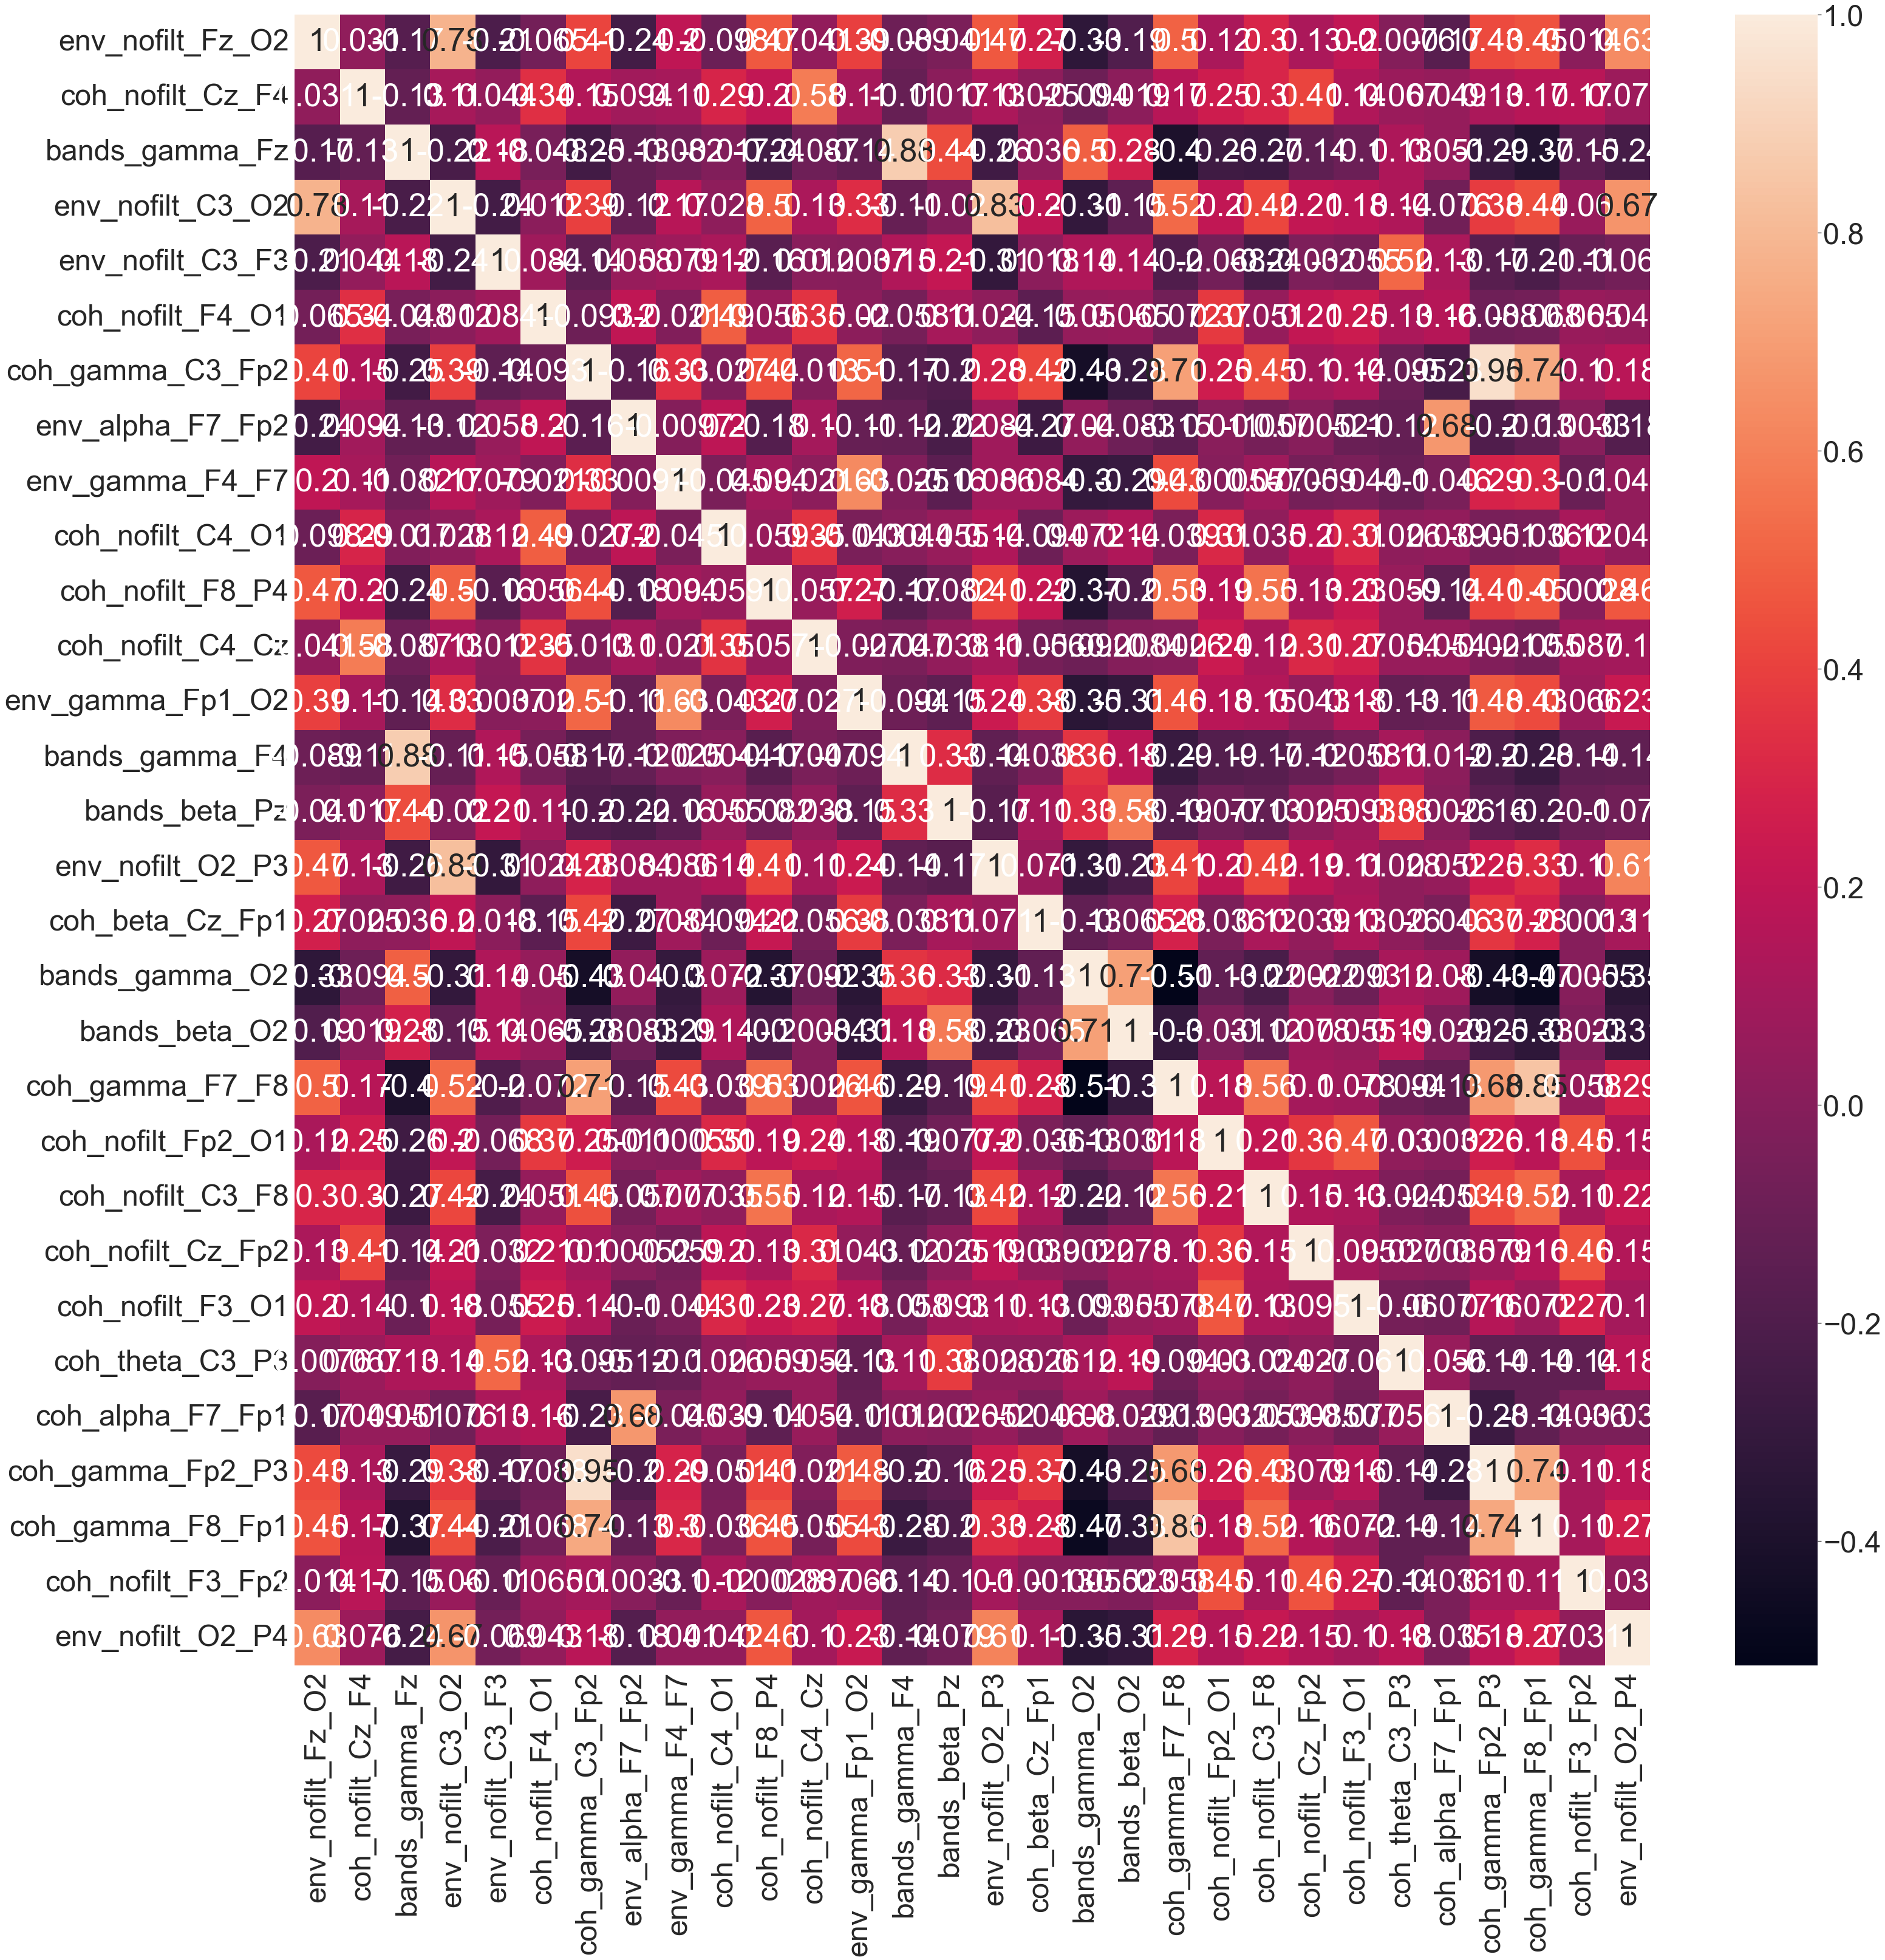

In [155]:
plt.figure(figsize=(50, 50))
svm=sn.heatmap(corrMatrix, annot=True)
figure = svm.get_figure()    
figure.savefig('corrMatrix.png', dpi=400)

In [156]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

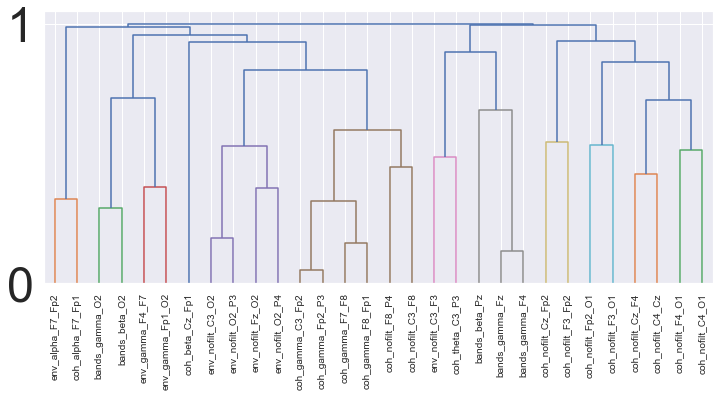

In [157]:
plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(corrMatrix)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=data_important.columns, orientation='top', 
           leaf_rotation=90);

In [158]:
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([ 3, 10,  7,  3,  6, 10,  4,  1,  2, 10,  4, 10,  2,  7,  7,  3,  5,
        2,  2,  4,  9,  4,  8,  9,  6,  1,  4,  4,  8,  3], dtype=int32)

In [159]:
sns.set(font_scale=4.4)

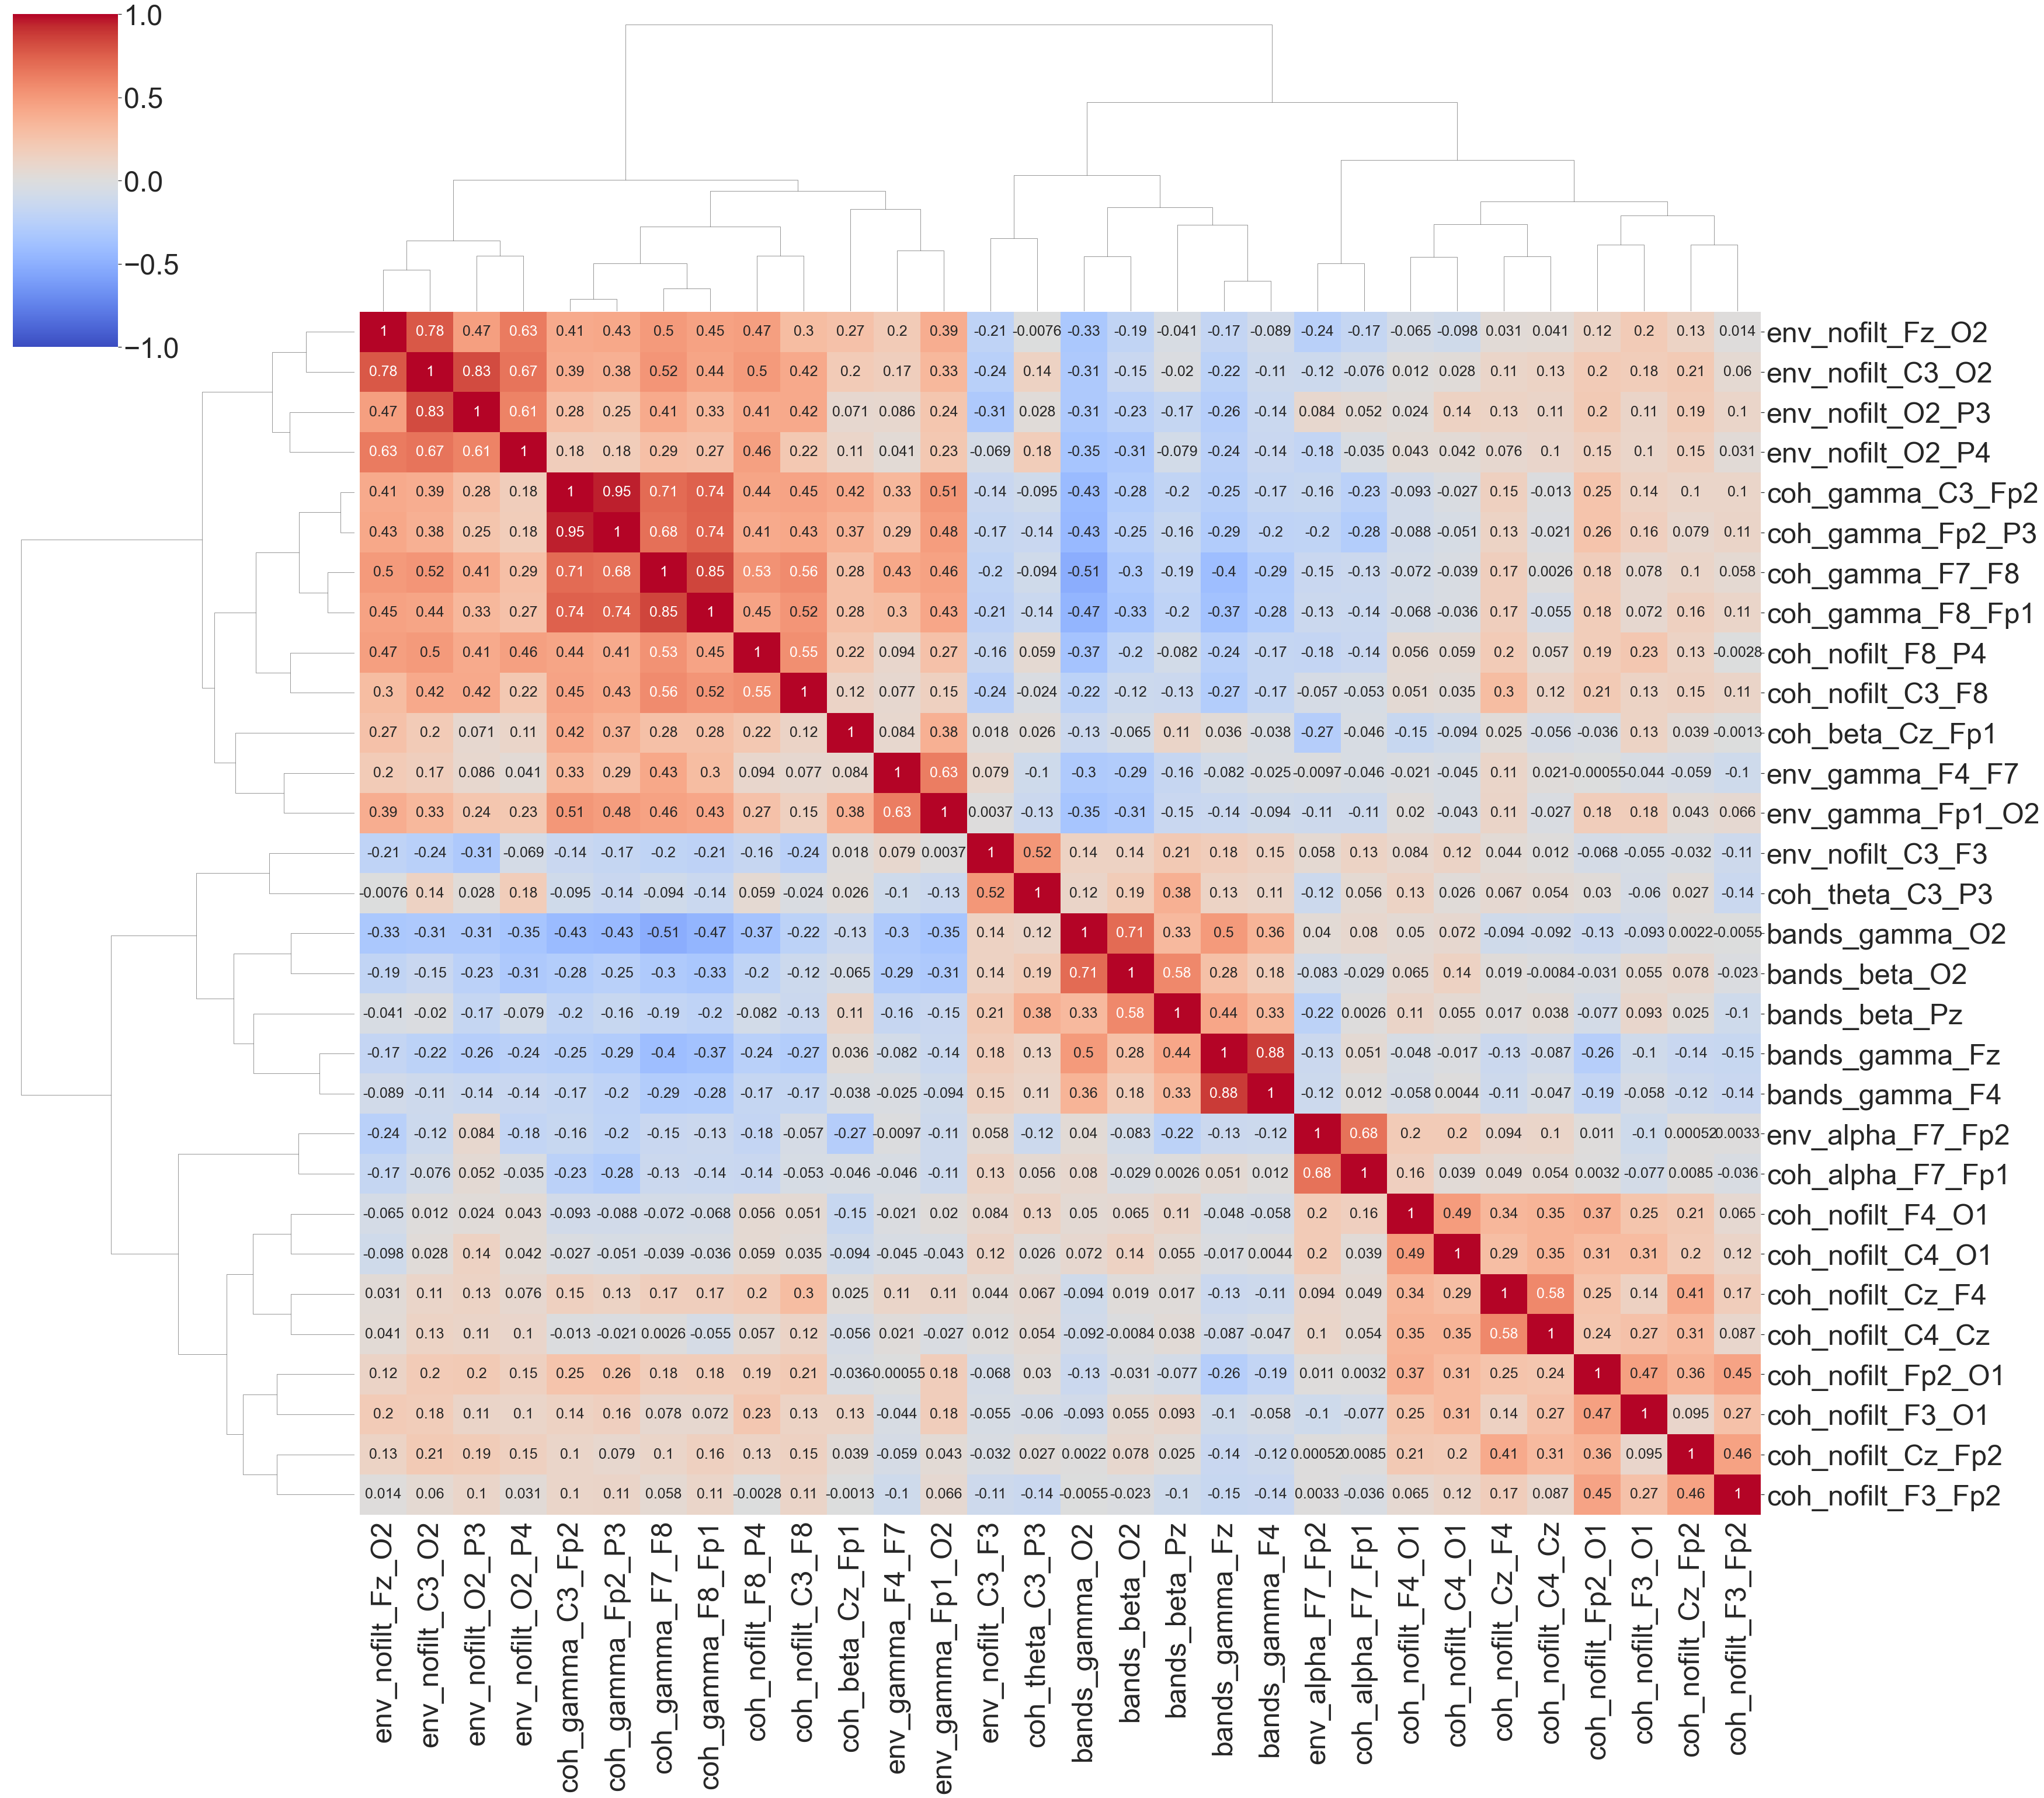

In [160]:
svm=sns.clustermap(corrMatrix, method="complete", cmap='coolwarm', annot=True, 
               annot_kws={"size": 25}, vmin=-1, vmax=1, figsize=(50,44))  
svm.savefig('clustercorrMatrix_v2.png', dpi=250)